<a href="https://colab.research.google.com/github/eridanletalis/GB_nn/blob/main/hw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install --upgrade pip
#!pip uninstall -y tensorflow-gpu
#!pip install tensorflow-gpu==2.4.1
#%tensorflow_version 2.4.1

Улучшение работы на MNIST

Подключаем библиотеки и подгружаем данные

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
# Проверим, что ГПУ включился
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
5.244927325999981
GPU (s):
0.05722952299998951
GPU speedup over CPU: 91x


In [4]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
# сразу подключим оптимизаторы, слои и прочее
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad
from __future__ import absolute_import, division, print_function, unicode_literals
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.models import Model
import tensorflow

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

Загружаем исходные данные

In [6]:
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [7]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [8]:
y_train_labels = to_categorical(train_labels)
y_test_labels = to_categorical(test_labels)

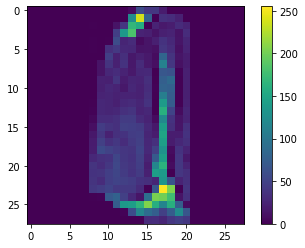

In [9]:
plt.figure()
plt.imshow(train_images[8879])
plt.colorbar()
plt.grid(False)
plt.show()

In [10]:
train_images = train_images / 255.0

test_images = test_images / 255.0

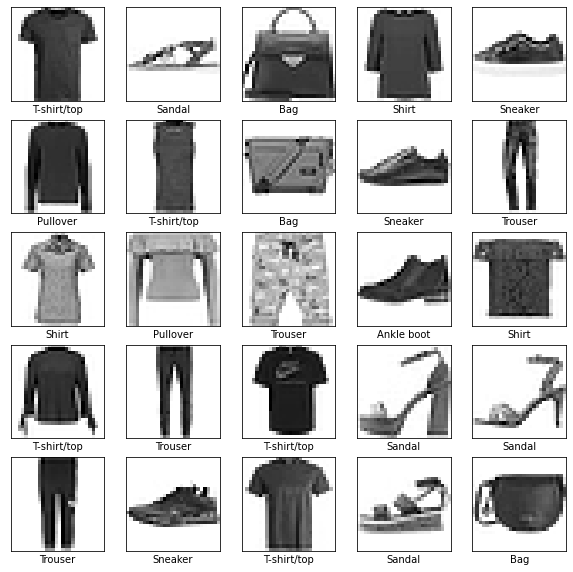

In [11]:
plt.figure(figsize=(10,10))
for i in range(154,179):
    plt.subplot(5,5,i+1-154)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

# Строим ИНС
Помня о том, что во второй работе увеличение колиества нейронов в слое не давало высокого прироста, а чрезмерное увеличение количества слоёв увеличивало переобучение, применим копромисное решение.

<strong>Вывод первый интересный: как и в биологической системе, в информационной решающее значение оказвыает число узлов нейронов - синапсов. Это увеличивает разнообразие возможных состояний сети.</strong>

<strong>Наблюдение из прошлого дз : чем больше нейронных связей, тем больше (до определённого предела) потребуется эпох, чтобы ИНС обучилась. Смотреть за переобучением можно с использованием <i>не рассмотренной на лекции</i> callback функции monitor. </strong> Реализовывать не стал - не успел.


In [12]:
# Количество слоёв выбиралось исходя из уменьшения вдвое числа входов
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(392, activation='relu'),
    keras.layers.LayerNormalization(),
    keras.layers.Dense(196, activation='relu'),
    keras.layers.Dense(98, activation='relu'),
    keras.layers.Dense(49, activation='relu'),
    keras.layers.Dropout(0.15),
    keras.layers.Dense(10)
])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 392)               307720    
                                                                 
 layer_normalization (LayerN  (None, 392)              784       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 196)               77028     
                                                                 
 dense_2 (Dense)             (None, 98)                19306     
                                                                 
 dense_3 (Dense)             (None, 49)                4851      
                                                        

In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
# Путём тестов выяснил, что аккуратность не растёт сильно после 32 эпохи
model.fit(train_images, y_train_labels, epochs=32, batch_size=64)

Epoch 1/32
938/938 [==============================] - 6s 4ms/step - loss: 0.5238 - accuracy: 0.8141
Epoch 2/32
938/938 [==============================] - 5s 5ms/step - loss: 0.3825 - accuracy: 0.8627
Epoch 3/32
938/938 [==============================] - 5s 6ms/step - loss: 0.3433 - accuracy: 0.8753
Epoch 4/32
938/938 [==============================] - 5s 6ms/step - loss: 0.3185 - accuracy: 0.8842
Epoch 5/32
938/938 [==============================] - 4s 5ms/step - loss: 0.3013 - accuracy: 0.8897
Epoch 6/32
938/938 [==============================] - 3s 4ms/step - loss: 0.2858 - accuracy: 0.8934
Epoch 7/32
938/938 [==============================] - 4s 4ms/step - loss: 0.2721 - accuracy: 0.8985
Epoch 8/32
938/938 [==============================] - 5s 5ms/step - loss: 0.2618 - accuracy: 0.9034
Epoch 9/32
938/938 [==============================] - 4s 4ms/step - loss: 0.2514 - accuracy: 0.9049
Epoch 10/32
938/938 [==============================] - 3s 4ms/step - loss: 0.2421 - accuracy: 0.9089

In [16]:
# Добившись немного лучших показателей, чем на лекции, решил остановиться на этом варианте сети
test_loss, test_acc = model.evaluate(test_images,  y_test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 1s - loss: 0.4403 - accuracy: 0.8968 - 804ms/epoch - 3ms/step

Test accuracy: 0.8967999815940857


In [17]:
y_p = model.predict(test_images[:1,:,:])
y_p

array([[-18.474373 , -22.490831 , -10.878454 , -16.836466 , -13.485521 ,
          2.063386 , -20.92947  ,   4.9425817, -15.134223 ,  16.458357 ]],
      dtype=float32)

In [18]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

In [19]:
predictions = probability_model.predict(test_images)

In [20]:
np.argmax(predictions[0])

9

In [21]:
test_labels[0]

9

In [22]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

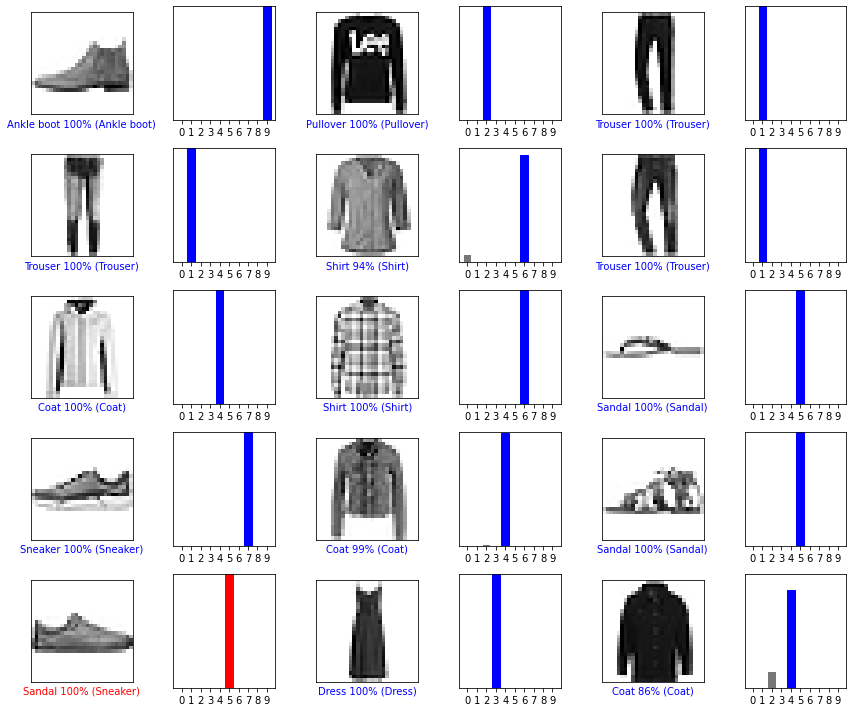

In [23]:

num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

#Теперь поработаем с тестами разных оптимизаторов для подобранной сети

In [24]:
import pandas as pd
from datetime import datetime
from tensorflow.keras import initializers

In [25]:
columns_1 = ("adam", "sgd", "rmsprop", "adagrad")
models_loss = pd.DataFrame(columns=columns_1)
models_acc = pd.DataFrame(columns=columns_1)

In [26]:
optimizers = ["adam", "sgd", "rmsprop", "adagrad"]

## Выполняем эксперимент на определение лучшего оптимизатора
Эксперимент будет выпоняться 15 раз с разными seed для усреднения при разных начальных состояниях. 
Записываем loss, acc.

Далее результат будет усреднён и выбрана модель с наилучшей комбинацией loss-acc. Учитываться будут средние значения и дисперсии.

In [27]:
# Количество слоёв выбиралось исходя из уменьшения вдвое числа входов
for i in range(1,16):
  for opt in optimizers:
    print(f"Выполняется проход {i}, оптимизатор {opt}")
    model = keras.Sequential([
        keras.layers.Flatten(input_shape=(28, 28)),
        keras.layers.Dense(392, activation='relu',
                           kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                  stddev=0.15, 
                                      seed=int(datetime.now().timestamp()))),
        keras.layers.Dense(196, activation='relu',
                           kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                  stddev=0.15, 
                                      seed=int(datetime.now().timestamp()))),
        keras.layers.LayerNormalization(),                      
        keras.layers.Dense(98, activation='relu',
                           kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                  stddev=0.15, 
                                      seed=int(datetime.now().timestamp()))),
        keras.layers.Dense(49, activation='relu',
                           kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                  stddev=0.15, 
                                      seed=int(datetime.now().timestamp()))),
        keras.layers.Dropout(0.15),
        keras.layers.Dense(10,
                           kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                  stddev=0.15, 
                                      seed=int(datetime.now().timestamp())))
    ])

    model.compile(optimizer=opt,
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    model.fit(train_images, y_train_labels, epochs=32, batch_size=64, verbose=0)

    test_loss, test_acc = model.evaluate(test_images,  y_test_labels, verbose=2)
    models_loss.loc[i, opt] = test_loss
    models_acc.loc[i, opt] = test_acc

Выполняется проход 1, оптимизатор adam
313/313 - 1s - loss: 0.4483 - accuracy: 0.8929 - 1s/epoch - 4ms/step
Выполняется проход 1, оптимизатор sgd
313/313 - 1s - loss: 0.3916 - accuracy: 0.8650 - 798ms/epoch - 3ms/step
Выполняется проход 1, оптимизатор rmsprop
313/313 - 1s - loss: 0.6081 - accuracy: 0.8710 - 784ms/epoch - 3ms/step
Выполняется проход 1, оптимизатор adagrad
313/313 - 1s - loss: 0.4295 - accuracy: 0.8485 - 798ms/epoch - 3ms/step
Выполняется проход 2, оптимизатор adam
313/313 - 1s - loss: 0.3922 - accuracy: 0.8927 - 772ms/epoch - 2ms/step
Выполняется проход 2, оптимизатор sgd
313/313 - 1s - loss: 0.3621 - accuracy: 0.8706 - 779ms/epoch - 2ms/step
Выполняется проход 2, оптимизатор rmsprop
313/313 - 1s - loss: 0.5542 - accuracy: 0.8790 - 788ms/epoch - 3ms/step
Выполняется проход 2, оптимизатор adagrad
313/313 - 1s - loss: 0.4282 - accuracy: 0.8489 - 800ms/epoch - 3ms/step
Выполняется проход 3, оптимизатор adam
313/313 - 1s - loss: 0.4744 - accuracy: 0.8896 - 799ms/epoch - 3ms

In [28]:
models_loss.astype(np.float64).describe()


,adam,sgd,rmsprop,adagrad
count,15.000000,15.000000,15.000000,15.000000
mean,0.424011,0.366776,0.565012,0.430075
std,0.022704,0.009339,0.063722,0.004130
min,0.392230,0.352472,0.463690,0.423553
25%,0.408602,0.362104,0.522091,0.427932
50%,0.419294,0.367353,0.566726,0.429560
75%,0.440967,0.370855,0.590798,0.430601
max,0.474427,0.391631,0.719102,0.439911


In [29]:
models_acc.astype(np.float64).describe()

,adam,sgd,rmsprop,adagrad
count,15.000000,15.000000,15.000000,15.000000
mean,0.893073,0.870167,0.879607,0.846207
std,0.002964,0.003079,0.009146,0.003028
min,0.887900,0.865000,0.857500,0.839500
25%,0.890650,0.868200,0.876500,0.844450
50%,0.893100,0.869800,0.879000,0.846400
75%,0.894500,0.872850,0.887350,0.848700
max,0.898200,0.874600,0.890800,0.851300


По совокупности факторов (самая лучшая accuracy и самый низкий разброс accuracy) лучшим оптимизатором для этой сети выходит adam.
следующие эксперименты будут использовать этот оптимизатор, кроме эксперимента с разными функциями потерь

<strong>Наблюдение 2: У Adam самый высокий разброс loss, но низкий разброс Accuracy значений. Возможно, следовало выбрать adagrad, т.к. высокий разброс может говорить о низкой стабильности сети - при разных начальных условиях получаем разные результаты. </strong>

#Выполняем эксперимент на выявление лучшей структуры ИНС

Текущую модель примем за базовую и выполним проверку с моделями, у которых:
1. Добавлены два слоя на перед первым (392*4,392*2)
2. Добавлен слой перед первым (392*2)
3. Убран первый слой 
4. Убран первый и второй слои


Примечание: после тестового запуска решил увеличить число эпох для х4 до 23, для х2 до 20. Для х0,25 уменьшить до 15

In [30]:
columns_2 = ("x4", "x2", "baseline", "x0.5", "x0.25")
models_loss = pd.DataFrame(columns=columns_2)
models_acc = pd.DataFrame(columns=columns_2)

In [31]:
models_acc

,x4,x2,baseline,x0.5,x0.25


In [32]:
models_loss

,x4,x2,baseline,x0.5,x0.25


In [33]:
print(392*4)
print(392*2)

1568
784


In [34]:
# Добившись немного лучших показателей, чем на лекции, решил остановиться на этом варианте сети
for i in range(1, 16):
  print(f"Выполняется проход {i} сеть х4")
  model = keras.Sequential([
      keras.layers.Flatten(input_shape=(28, 28)),
      keras.layers.Dense(1568, activation='relu',
                          kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                stddev=0.15, 
                                    seed=int(datetime.now().timestamp()))),
      keras.layers.Dense(784, activation='relu',
                          kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                stddev=0.15, 
                                    seed=int(datetime.now().timestamp()))),
      keras.layers.Dense(392, activation='relu',
                          kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                stddev=0.15, 
                                    seed=int(datetime.now().timestamp()))),
      keras.layers.LayerNormalization(),                      
      keras.layers.Dense(196, activation='relu',
                          kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                stddev=0.15, 
                                    seed=int(datetime.now().timestamp()))),
      keras.layers.Dense(98, activation='relu',
                          kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                stddev=0.15, 
                                    seed=int(datetime.now().timestamp()))),
      keras.layers.Dense(49, activation='relu',
                          kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                stddev=0.15, 
                                    seed=int(datetime.now().timestamp()))),
      keras.layers.Dropout(0.15),
      keras.layers.Dense(10,
                          kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                stddev=0.15, 
                                    seed=int(datetime.now().timestamp())))
  ])

  model.compile(optimizer='adam',
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  model.fit(train_images, y_train_labels, epochs=64, batch_size=64, verbose=0)

  test_loss, test_acc = model.evaluate(test_images,  y_test_labels, verbose=2)
  models_loss.loc[i, "x4"] = test_loss
  models_acc.loc[i, "x4"] = test_acc

  print(f"Выполняется проход {i} сеть х2")
  model = keras.Sequential([
      keras.layers.Flatten(input_shape=(28, 28)),
      keras.layers.Dense(784, activation='relu',
                          kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                stddev=0.15, 
                                    seed=int(datetime.now().timestamp()))),
      keras.layers.Dense(392, activation='relu',
                          kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                stddev=0.15, 
                                    seed=int(datetime.now().timestamp()))),
      keras.layers.LayerNormalization(),                      
      keras.layers.Dense(196, activation='relu',
                          kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                stddev=0.15, 
                                    seed=int(datetime.now().timestamp()))),
      keras.layers.Dense(98, activation='relu',
                          kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                stddev=0.15, 
                                    seed=int(datetime.now().timestamp()))),
      keras.layers.Dense(49, activation='relu',
                          kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                stddev=0.15, 
                                    seed=int(datetime.now().timestamp()))),
      keras.layers.Dropout(0.15),                      
      keras.layers.Dense(10,
                          kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                stddev=0.15, 
                                    seed=int(datetime.now().timestamp())))
  ])

  model.compile(optimizer='adam',
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  model.fit(train_images, y_train_labels, epochs=32, batch_size=64, verbose=0)

  test_loss, test_acc = model.evaluate(test_images,  y_test_labels, verbose=2)
  models_loss.loc[i, "x2"] = test_loss
  models_acc.loc[i, "x2"] = test_acc

  print(f"Выполняется проход {i} сеть baseline")
  model = keras.Sequential([
      keras.layers.Flatten(input_shape=(28, 28)),
      keras.layers.Dense(392, activation='relu',
                          kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                stddev=0.15, 
                                    seed=int(datetime.now().timestamp()))),
      keras.layers.Dense(196, activation='relu',
                          kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                stddev=0.15, 
                                    seed=int(datetime.now().timestamp()))),
      keras.layers.LayerNormalization(),                      
      keras.layers.Dense(98, activation='relu',
                          kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                stddev=0.15, 
                                    seed=int(datetime.now().timestamp()))),
      keras.layers.Dense(49, activation='relu',
                          kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                stddev=0.15, 
                                    seed=int(datetime.now().timestamp()))),
      keras.layers.Dropout(0.15),
      keras.layers.Dense(10,
                          kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                stddev=0.15, 
                                    seed=int(datetime.now().timestamp())))
  ])

  model.compile(optimizer='adam',
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  model.fit(train_images, y_train_labels, epochs=32, batch_size=64, verbose=0)

  test_loss, test_acc = model.evaluate(test_images,  y_test_labels, verbose=2)
  models_loss.loc[i, "baseline"] = test_loss
  models_acc.loc[i, "baseline"] = test_acc
 
  print(f"Выполняется проход {i} сеть x0.5")
  model = keras.Sequential([
      keras.layers.Flatten(input_shape=(28, 28)),
      keras.layers.Dense(196, activation='relu',
                          kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                stddev=0.15, 
                                    seed=int(datetime.now().timestamp()))),
      keras.layers.Dense(98, activation='relu',
                          kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                stddev=0.15, 
                                    seed=int(datetime.now().timestamp()))),
      keras.layers.LayerNormalization(),                      
      keras.layers.Dense(49, activation='relu',
                          kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                stddev=0.15, 
                                    seed=int(datetime.now().timestamp()))),
      keras.layers.Dropout(0.15),
      keras.layers.Dense(10,
                          kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                stddev=0.15, 
                                    seed=int(datetime.now().timestamp())))
  ])

  model.compile(optimizer='adam',
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  model.fit(train_images, y_train_labels, epochs=32, batch_size=64, verbose=0)

  test_loss, test_acc = model.evaluate(test_images,  y_test_labels, verbose=2)
  models_loss.loc[i, "x0.5"] = test_loss
  models_acc.loc[i, "x0.5"] = test_acc

  print(f"Выполняется проход {i} сеть x0.25")
  model = keras.Sequential([
      keras.layers.Flatten(input_shape=(28, 28)),
      keras.layers.Dense(98, activation='relu',
                          kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                stddev=0.15, 
                                    seed=int(datetime.now().timestamp()))),
      keras.layers.LayerNormalization(),                      
      keras.layers.Dense(49, activation='relu',
                          kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                stddev=0.15, 
                                    seed=int(datetime.now().timestamp()))),
      keras.layers.Dropout(0.15),
      keras.layers.Dense(10,
                          kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                stddev=0.15, 
                                    seed=int(datetime.now().timestamp())))
  ])

  model.compile(optimizer='adam',
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  model.fit(train_images, y_train_labels, epochs=32, batch_size=64, verbose=0)

  test_loss, test_acc = model.evaluate(test_images,  y_test_labels, verbose=2)
  models_loss.loc[i, "x0.25"] = test_loss
  models_acc.loc[i, "x0.25"] = test_acc


Выполняется проход 1 сеть х4
313/313 - 1s - loss: 0.6112 - accuracy: 0.9020 - 827ms/epoch - 3ms/step
Выполняется проход 1 сеть х2
313/313 - 1s - loss: 0.4351 - accuracy: 0.8890 - 840ms/epoch - 3ms/step
Выполняется проход 1 сеть baseline
313/313 - 1s - loss: 0.4216 - accuracy: 0.8922 - 799ms/epoch - 3ms/step
Выполняется проход 1 сеть x0.5
313/313 - 1s - loss: 0.4054 - accuracy: 0.8933 - 762ms/epoch - 2ms/step
Выполняется проход 1 сеть x0.25
313/313 - 1s - loss: 0.3871 - accuracy: 0.8882 - 762ms/epoch - 2ms/step
Выполняется проход 2 сеть х4
313/313 - 1s - loss: 0.6401 - accuracy: 0.8993 - 831ms/epoch - 3ms/step
Выполняется проход 2 сеть х2
313/313 - 1s - loss: 0.4056 - accuracy: 0.8951 - 805ms/epoch - 3ms/step
Выполняется проход 2 сеть baseline
313/313 - 1s - loss: 0.3973 - accuracy: 0.8981 - 785ms/epoch - 3ms/step
Выполняется проход 2 сеть x0.5
313/313 - 1s - loss: 0.4245 - accuracy: 0.8846 - 775ms/epoch - 2ms/step
Выполняется проход 2 сеть x0.25
313/313 - 1s - loss: 0.4039 - accuracy: 

In [35]:
models_loss.astype(np.float64).describe()

,x4,x2,baseline,x0.5,x0.25
count,15.000000,15.000000,15.000000,15.000000,15.000000
mean,0.606862,0.419843,0.438274,0.416537,0.386258
std,0.050870,0.016814,0.021666,0.020654,0.014664
min,0.529774,0.382618,0.397329,0.386242,0.362519
25%,0.567866,0.412312,0.423196,0.399246,0.376396
50%,0.611223,0.423528,0.441076,0.415673,0.387106
75%,0.643797,0.431316,0.448422,0.431075,0.394917
max,0.689412,0.447593,0.485010,0.452607,0.413379


In [ ]:
print(12345)

In [36]:
models_acc.astype(np.float64).describe()

,x4,x2,baseline,x0.5,x0.25
count,15.000000,15.000000,15.000000,15.000000,15.000000
mean,0.898973,0.894567,0.893313,0.890947,0.885513
std,0.002378,0.003546,0.002618,0.002807,0.002710
min,0.893800,0.887400,0.889800,0.884600,0.881300
25%,0.897700,0.891900,0.890950,0.889200,0.882850
50%,0.899300,0.895600,0.892800,0.891900,0.885400
75%,0.900450,0.897300,0.895050,0.892900,0.887550
max,0.902600,0.898700,0.898100,0.894900,0.890600


Модель x0.25 показала наилучшие результаты. у неё самый низкий показатель функции потерь и самый низкий разброс при разных начальных значениях. Она будет использована при проверках разных функций потерь

# Выполняем тестирование функций потерь

In [37]:
models_loss = pd.DataFrame(columns=columns_1)
models_acc = pd.DataFrame(columns=columns_1)

models_loss_std = pd.DataFrame(columns=columns_1)
models_acc_std = pd.DataFrame(columns=columns_1)

In [38]:
models_loss

,adam,sgd,rmsprop,adagrad


In [39]:
models_loss_std

,adam,sgd,rmsprop,adagrad


In [40]:
models_acc

,adam,sgd,rmsprop,adagrad


In [41]:
models_acc_std

,adam,sgd,rmsprop,adagrad


In [42]:
optimizers

['adam', 'sgd', 'rmsprop', 'adagrad']

In [43]:
catcrosstrue = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
catcrossfalse = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
cathinge = tf.keras.losses.CategoricalHinge()
mae = tf.keras.losses.MeanAbsoluteError()
mse = tf.keras.losses.MeanSquaredError()
msle = tf.keras.losses.MeanSquaredLogarithmicError()
poison = tf.keras.losses.Poisson()
kld = tf.keras.losses.KLDivergence()
losses = [catcrosstrue, catcrossfalse, cathinge, cathinge, mae, mse, msle, poison, kld]
losses_names = ["catcrosstrue", "catcrossfalse", "cathinge", "cathinge", "mae", "mse", "msle", "poison", "kld"]
losses

In [44]:
losses_names

['catcrosstrue',
 'catcrossfalse',
 'cathinge',
 'cathinge',
 'mae',
 'mse',
 'msle',
 'poison',
 'kld']

**Текст, выделенный полужирным шрифтом**

In [ ]:
for j,ls in enumerate(losses):
  for opt in optimizers:
    loss_tst = []
    acc_tst = []
    for i in range(1,16):
      print(f"Выполняется проход {i} сеть x0.25, оптимизатор {opt}, \
      функция потерь {ls}")
      model = keras.Sequential([
          keras.layers.Flatten(input_shape=(28, 28)),
          keras.layers.Dense(98, activation='relu',
                              kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                    stddev=0.15, 
                                        seed=int(datetime.now().timestamp()))),
          keras.layers.LayerNormalization(),                      
          keras.layers.Dense(49, activation='relu',
                              kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                    stddev=0.15, 
                                        seed=int(datetime.now().timestamp()))),
          keras.layers.Dropout(0.15),
          keras.layers.Dense(10,
                              kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                    stddev=0.15, 
                                        seed=int(datetime.now().timestamp())))
      ])

      model.compile(optimizer=opt,
                    loss=ls,
                    metrics=['accuracy'])

      model.fit(train_images, y_train_labels, epochs=64, batch_size=64, verbose=0)

      test_loss, test_acc = model.evaluate(test_images,  y_test_labels, verbose=2)
      loss_tst.append(test_loss)
      acc_tst.append(test_acc)

    models_loss.loc[losses_names[j], opt] = np.array(loss_tst).mean()
    models_acc.loc[losses_names[j], opt] = np.array(test_acc).mean()
    models_loss_std.loc[losses_names[j], opt] = np.array(loss_tst).std()
    models_acc_std.loc[losses_names[j], opt] = np.array(test_acc).std()

Выполняется проход 1 сеть x0.25, оптимизатор adam,       функция потерь <keras.losses.CategoricalCrossentropy object at 0x7f41dc2465d0>
313/313 - 1s - loss: 0.4996 - accuracy: 0.8843 - 723ms/epoch - 2ms/step
Выполняется проход 2 сеть x0.25, оптимизатор adam,       функция потерь <keras.losses.CategoricalCrossentropy object at 0x7f41dc2465d0>
313/313 - 1s - loss: 0.4998 - accuracy: 0.8877 - 729ms/epoch - 2ms/step
Выполняется проход 3 сеть x0.25, оптимизатор adam,       функция потерь <keras.losses.CategoricalCrossentropy object at 0x7f41dc2465d0>
313/313 - 1s - loss: 0.5089 - accuracy: 0.8890 - 736ms/epoch - 2ms/step
Выполняется проход 4 сеть x0.25, оптимизатор adam,       функция потерь <keras.losses.CategoricalCrossentropy object at 0x7f41dc2465d0>
313/313 - 1s - loss: 0.4772 - accuracy: 0.8872 - 720ms/epoch - 2ms/step
Выполняется проход 5 сеть x0.25, оптимизатор adam,       функция потерь <keras.losses.CategoricalCrossentropy object at 0x7f41dc2465d0>
313/313 - 1s - loss: 0.5276 - ac

In [ ]:
models_loss
 

In [ ]:
models_acc


In [ ]:
models_loss_std


In [ ]:
models_acc_std

# Вывод
Проведённый эксперимент показал, что опять для поиска лучших значений необходимо проверять абсолютно все параметры.
Не совсем ясно, до какого предела увеличивать "слойность" сети.
Предполагаю, что при изменении глубины слоёв будут разные значения для разных оптимизаторв, функций потерь и соответствующих функций активации.

Оптимизатор Adam показывает лучшие результаты по точности и потерям, но средние по разбросу (неустойчивости результатов при серии запусков).

Почему - не понятно.


# Работаем с данными sklearn.datasets import load_boston

In [ ]:
data = tf.keras.datasets.boston_housing.load_data()

In [ ]:
(train_x,train_y),(test_x,test_y) = data

In [ ]:
train_x

In [ ]:
model = tf.keras.models.Sequential([
Dense(169,"relu",input_shape=(train_x.shape[-1],)),
Dense(1)
])
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

In [ ]:
model.summary()

In [ ]:
model.fit(train_x, train_y, epochs=100, 
          validation_data=(test_x[51:],test_y[51:]))

In [ ]:
model.evaluate(test_x,test_y)

Текущий результат запишем как опорный и начнём экспериметы.

# Эксперимент с увеличением количества слоёв

Будет создано 5 разных ИНС:
1. Один слой, число нейронов 13
2. Один слой, число нейронов 26
3. Один слой, число нейронов 52
4. Один слой, число нейронов 13x13
5. Два слоя, число нейронов 13x13, 13
6. Два слоя, число нейронов 13x13, 13x13
7. Три слоя, число нейронов 52, 26, 13
8. Три слоя, число нейронов 13x13, 13x13, 13x13
9. Десять слоёв, число нейронов 13 в каждом
10. Десять слоёв, число нейронов 13x13 в каждом

Эксперимент будет запущен 15 раз каждый и вычислены среднее и дисперсии метрик. 
Фиксируем число эпох - 200 и критерий mae

Сначала работаем с relu, затем с sigmoid

In [ ]:
columns_1 = [
             "1-13",
             "1-26",
             "1-52",
             "1-13x13",
             "1-13x13,2-13",
             "1-13x13,2-13x13",
             "1-52,2-26,3-13",
             "1-13x13,2-13x13,3-13x13",
             "x10-13",
             "x10-13x13"
]
models_loss = pd.DataFrame(columns=columns_1)
models_mae = pd.DataFrame(columns=columns_1)

# models_loss_std = pd.DataFrame(columns=columns_1)
# models_mae_std = pd.DataFrame(columns=columns_1)

In [ ]:
models_loss

In [ ]:
for i in range (1,16):
  print(f"Выполняется проход {i}, сеть {columns_1[0]}")
  model = tf.keras.models.Sequential([
  Dense(13,"relu",input_shape=(train_x.shape[-1],)),
  Dense(1)
  ])
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  model.fit(train_x, train_y, epochs=200, verbose=0,
          validation_data=(test_x[51:],test_y[51:]))
  loss, mae = model.evaluate(test_x,test_y)
  models_loss.loc[i, columns_1[0]] = loss
  models_mae.loc[i, columns_1[0]] = mae

  print(f"Выполняется проход {i}, сеть {columns_1[1]}")
  model = tf.keras.models.Sequential([
  Dense(26,"relu",input_shape=(train_x.shape[-1],)),
  Dense(1)
  ])
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  model.fit(train_x, train_y, epochs=200, verbose=0,
          validation_data=(test_x[51:],test_y[51:]))
  loss, mae = model.evaluate(test_x,test_y)
  models_loss.loc[i, columns_1[1]] = loss
  models_mae.loc[i, columns_1[1]] = mae

  print(f"Выполняется проход {i}, сеть {columns_1[2]}")
  model = tf.keras.models.Sequential([
  Dense(52,"relu",input_shape=(train_x.shape[-1],)),
  Dense(1)
  ])
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  model.fit(train_x, train_y, epochs=200, verbose=0,
          validation_data=(test_x[51:],test_y[51:]))
  loss, mae = model.evaluate(test_x,test_y)
  models_loss.loc[i, columns_1[2]] = loss
  models_mae.loc[i, columns_1[2]] = mae

  print(f"Выполняется проход {i}, сеть {columns_1[3]}")
  model = tf.keras.models.Sequential([
  Dense(169,"relu",input_shape=(train_x.shape[-1],)),
  Dense(1)
  ])
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  model.fit(train_x, train_y, epochs=200, verbose=0,
          validation_data=(test_x[51:],test_y[51:]))
  loss, mae = model.evaluate(test_x,test_y)
  models_loss.loc[i, columns_1[3]] = loss
  models_mae.loc[i, columns_1[3]] = mae

  print(f"Выполняется проход {i}, сеть {columns_1[4]}")
  model = tf.keras.models.Sequential([
  Dense(169,"relu",input_shape=(train_x.shape[-1],)),
  Dense(13,"relu"),
  Dense(1)
  ])
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  model.fit(train_x, train_y, epochs=200, verbose=0,
          validation_data=(test_x[51:],test_y[51:]))
  loss, mae = model.evaluate(test_x,test_y)
  models_loss.loc[i, columns_1[4]] = loss
  models_mae.loc[i, columns_1[4]] = mae

  print(f"Выполняется проход {i}, сеть {columns_1[5]}")
  model = tf.keras.models.Sequential([
  Dense(169,"relu",input_shape=(train_x.shape[-1],)),
  Dense(169,"relu"),
  keras.layers.Dropout(0.15),
  Dense(1)
  ])
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  model.fit(train_x, train_y, epochs=200, verbose=0,
          validation_data=(test_x[51:],test_y[51:]))
  loss, mae = model.evaluate(test_x,test_y)
  models_loss.loc[i, columns_1[5]] = loss
  models_mae.loc[i, columns_1[5]] = mae

  print(f"Выполняется проход {i}, сеть {columns_1[6]}")
  model = tf.keras.models.Sequential([
  Dense(52,"relu",input_shape=(train_x.shape[-1],)),
  Dense(26,"relu"),
  keras.layers.LayerNormalization(),
  Dense(13,"relu"),
  keras.layers.Dropout(0.15),
  Dense(1)
  ])
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  model.fit(train_x, train_y, epochs=200, verbose=0,
          validation_data=(test_x[51:],test_y[51:]))
  loss, mae = model.evaluate(test_x,test_y)
  models_loss.loc[i, columns_1[6]] = loss
  models_mae.loc[i, columns_1[6]] = mae

  print(f"Выполняется проход {i}, сеть {columns_1[7]}")
  model = tf.keras.models.Sequential([
  Dense(169,"relu",input_shape=(train_x.shape[-1],)),
  Dense(169,"relu"),
  keras.layers.LayerNormalization(),
  Dense(169,"relu"),
  keras.layers.Dropout(0.15),
  Dense(1)
  ])
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  model.fit(train_x, train_y, epochs=200, verbose=0,
          validation_data=(test_x[51:],test_y[51:]))
  loss, mae = model.evaluate(test_x,test_y)
  models_loss.loc[i, columns_1[7]] = loss
  models_mae.loc[i, columns_1[7]] = mae

  print(f"Выполняется проход {i}, сеть {columns_1[8]}")
  model = tf.keras.models.Sequential([
  Dense(13,"relu",input_shape=(train_x.shape[-1],)),
  Dense(13,"relu"),
  Dense(13,"relu"),
  keras.layers.LayerNormalization(),
  Dense(13,"relu"),
  Dense(13,"relu"),
  Dense(13,"relu"),
  Dense(13,"relu"),
  Dense(13,"relu"),
  Dense(13,"relu"),
  Dense(13,"relu"),
  keras.layers.Dropout(0.15),
  Dense(1)
  ])
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  model.fit(train_x, train_y, epochs=200, verbose=0,
          validation_data=(test_x[51:],test_y[51:]))
  loss, mae = model.evaluate(test_x,test_y)
  models_loss.loc[i, columns_1[8]] = loss
  models_mae.loc[i, columns_1[8]] = mae

  print(f"Выполняется проход {i}, сеть {columns_1[9]}")
  model = tf.keras.models.Sequential([
  Dense(169,"relu",input_shape=(train_x.shape[-1],)),
  Dense(169,"relu"),
  Dense(169,"relu"),
  Dense(169,"relu"),
  Dense(169,"relu"),
  keras.layers.LayerNormalization(),
  Dense(169,"relu"),
  Dense(169,"relu"),
  Dense(169,"relu"),
  Dense(169,"relu"),
  Dense(169,"relu"),
  keras.layers.Dropout(0.15),
  Dense(1)
  ])
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  model.fit(train_x, train_y, epochs=200, verbose=0,
          validation_data=(test_x[51:],test_y[51:]))
  loss, mae = model.evaluate(test_x,test_y)
  models_loss.loc[i, columns_1[9]] = loss
  models_mae.loc[i, columns_1[9]] = mae

In [ ]:
models_loss


In [ ]:
models_mae

In [ ]:
models_loss.astype(np.float64).describe()

In [ ]:
models_mae.astype(np.float64).describe()

In [ ]:
models2_loss = pd.DataFrame(columns=columns_1)
models2_mae = pd.DataFrame(columns=columns_1)

In [ ]:
for i in range (1,16):
  print(f"Выполняется проход {i}, сеть {columns_1[0]}")
  model = tf.keras.models.Sequential([
  Dense(13,"sigmoid",input_shape=(train_x.shape[-1],)),
  Dense(1)
  ])
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  model.fit(train_x, train_y, epochs=200, verbose=0,
          validation_data=(test_x[51:],test_y[51:]))
  loss, mae = model.evaluate(test_x,test_y)
  models2_loss.loc[i, columns_1[0]] = loss
  models2_mae.loc[i, columns_1[0]] = mae

  print(f"Выполняется проход {i}, сеть {columns_1[1]}")
  model = tf.keras.models.Sequential([
  Dense(26,"sigmoid",input_shape=(train_x.shape[-1],)),
  Dense(1)
  ])
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  model.fit(train_x, train_y, epochs=200, verbose=0,
          validation_data=(test_x[51:],test_y[51:]))
  loss, mae = model.evaluate(test_x,test_y)
  models2_loss.loc[i, columns_1[1]] = loss
  models2_mae.loc[i, columns_1[1]] = mae

  print(f"Выполняется проход {i}, сеть {columns_1[2]}")
  model = tf.keras.models.Sequential([
  Dense(52,"sigmoid",input_shape=(train_x.shape[-1],)),
  Dense(1)
  ])
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  model.fit(train_x, train_y, epochs=200, verbose=0,
          validation_data=(test_x[51:],test_y[51:]))
  loss, mae = model.evaluate(test_x,test_y)
  models2_loss.loc[i, columns_1[2]] = loss
  models2_mae.loc[i, columns_1[2]] = mae

  print(f"Выполняется проход {i}, сеть {columns_1[3]}")
  model = tf.keras.models.Sequential([
  Dense(169,"sigmoid",input_shape=(train_x.shape[-1],)),
  Dense(1)
  ])
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  model.fit(train_x, train_y, epochs=200, verbose=0,
          validation_data=(test_x[51:],test_y[51:]))
  loss, mae = model.evaluate(test_x,test_y)
  models2_loss.loc[i, columns_1[3]] = loss
  models2_mae.loc[i, columns_1[3]] = mae

  print(f"Выполняется проход {i}, сеть {columns_1[4]}")
  model = tf.keras.models.Sequential([
  Dense(169,"sigmoid",input_shape=(train_x.shape[-1],)),
  Dense(13,"sigmoid"),
  keras.layers.Dropout(0.15),
  Dense(1)
  ])
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  model.fit(train_x, train_y, epochs=200, verbose=0,
          validation_data=(test_x[51:],test_y[51:]))
  loss, mae = model.evaluate(test_x,test_y)
  models2_loss.loc[i, columns_1[4]] = loss
  models2_mae.loc[i, columns_1[4]] = mae

  print(f"Выполняется проход {i}, сеть {columns_1[5]}")
  model = tf.keras.models.Sequential([
  Dense(169,"sigmoid",input_shape=(train_x.shape[-1],)),
  Dense(169,"sigmoid"),
  keras.layers.Dropout(0.15),
  Dense(1)
  ])
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  model.fit(train_x, train_y, epochs=200, verbose=0,
          validation_data=(test_x[51:],test_y[51:]))
  loss, mae = model.evaluate(test_x,test_y)
  models2_loss.loc[i, columns_1[5]] = loss
  models2_mae.loc[i, columns_1[5]] = mae

  print(f"Выполняется проход {i}, сеть {columns_1[6]}")
  model = tf.keras.models.Sequential([
  Dense(52,"sigmoid",input_shape=(train_x.shape[-1],)),
  Dense(26,"sigmoid"),
  Dense(13,"sigmoid"),
  keras.layers.Dropout(0.15),
  Dense(1)
  ])
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  model.fit(train_x, train_y, epochs=200, verbose=0,
          validation_data=(test_x[51:],test_y[51:]))
  loss, mae = model.evaluate(test_x,test_y)
  models2_loss.loc[i, columns_1[6]] = loss
  models2_mae.loc[i, columns_1[6]] = mae

  print(f"Выполняется проход {i}, сеть {columns_1[7]}")
  model = tf.keras.models.Sequential([
  Dense(169,"sigmoid",input_shape=(train_x.shape[-1],)),
  Dense(169,"sigmoid"),
  Dense(169,"sigmoid"),
  keras.layers.Dropout(0.15),
  Dense(1)
  ])
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  model.fit(train_x, train_y, epochs=200, verbose=0,
          validation_data=(test_x[51:],test_y[51:]))
  loss, mae = model.evaluate(test_x,test_y)
  models2_loss.loc[i, columns_1[7]] = loss
  models2_mae.loc[i, columns_1[7]] = mae

  print(f"Выполняется проход {i}, сеть {columns_1[8]}")
  model = tf.keras.models.Sequential([
  Dense(13,"sigmoid",input_shape=(train_x.shape[-1],)),
  Dense(13,"sigmoid"),
  Dense(13,"sigmoid"),
  Dense(13,"sigmoid"),
  keras.layers.LayerNormalization(),
  Dense(13,"sigmoid"),
  Dense(13,"sigmoid"),
  Dense(13,"sigmoid"),
  Dense(13,"sigmoid"),
  Dense(13,"sigmoid"),
  Dense(13,"sigmoid"),
  keras.layers.Dropout(0.15),
  Dense(1)
  ])
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  model.fit(train_x, train_y, epochs=200, verbose=0,
          validation_data=(test_x[51:],test_y[51:]))
  loss, mae = model.evaluate(test_x,test_y)
  models2_loss.loc[i, columns_1[8]] = loss
  models2_mae.loc[i, columns_1[8]] = mae

  print(f"Выполняется проход {i}, сеть {columns_1[9]}")
  model = tf.keras.models.Sequential([
  Dense(169,"sigmoid",input_shape=(train_x.shape[-1],)),
  Dense(169,"sigmoid"),
  Dense(169,"sigmoid"),
  Dense(169,"sigmoid"),
  keras.layers.LayerNormalization(),
  Dense(169,"sigmoid"),
  Dense(169,"sigmoid"),
  Dense(169,"sigmoid"),
  Dense(169,"sigmoid"),
  Dense(169,"sigmoid"),
  Dense(169,"sigmoid"),
  keras.layers.Dropout(0.15),
  Dense(1)
  ])
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  model.fit(train_x, train_y, epochs=200, verbose=0,
          validation_data=(test_x[51:],test_y[51:]))
  loss, mae = model.evaluate(test_x,test_y)
  models2_loss.loc[i, columns_1[9]] = loss
  models2_mae.loc[i, columns_1[9]] = mae

In [ ]:
models2_loss

In [ ]:
models2_mae

In [ ]:
models2_loss.astype(np.float64).describe()

In [ ]:
models2_mae.astype(np.float64).describe()

Среди ReLu сетей лучшими являются многослойные, либо однослойная с большим числом нейронов. Возможно, это связано с тем, что ReLu линейная и нелинейность данных хорошо повторяется (моделируется, воспроизводится) нелинейностью связей между нейронами.
Среди сетей, построенных на сигмоиде лучшими результатами обладают сети, состоящие из 169 нейронов в слое - одна и двуслойная. Число нейронов выбрано, как квадрат числа входов.

Сети, состоящие из 10 слоёв, обладают лучшей стабильностью, что странно - бОльшее число связей должны были дать бОльшую вариацию решений. Возможно, дело в том, что данные имеют хороший локальный минимум. 

Лушие архитектуры сетей собраны ниже для дальнейшего анализа. 
Также добавлены глубокие сети.

# Эксперименты с выбранными архитектурами ИНС

Целью этого эксперимента является проверка архитектур на устойчивость при разных начальных позициях (разные сиды).

В основном, этот эскперимент выполняется, потому что я увидел у десятислойной сети на сигмоидах низкий разброс потерь и mae. Возможно, это связано с тем, что при такой глубине у сигмоид проявляется проблема с очень небольшой производной. Или это какая-то аномальная устойчивоть. Будет выполнено 30 проходов, вместо 15. Также проверке подвергнуться выбранные архитектуры сетей. 

In [ ]:
columns_1 = [
             "1-169ReLu",
             "1-169,2-169ReLu",
             "1-169Sigmoid",
             "1-169,2-169Sigmoid",
             "x10-13Sigmoid",
             "x10-169Sigmoid",
             "x10-13Relu",
             "x10-169Relu"
]
models_loss = pd.DataFrame(columns=columns_1)
models_mae = pd.DataFrame(columns=columns_1)

In [ ]:
models_loss


In [ ]:
models_mae

In [ ]:
for i in range (1,31):
  print(f"Выполняется проход {i}, сеть {columns_1[0]}")
  model = tf.keras.models.Sequential([
  Dense(169,"relu", input_shape=(train_x.shape[-1],), kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
  Dense(1, kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp())))
  ])
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  model.fit(train_x, train_y, epochs=200, verbose=0,
          validation_data=(test_x[51:],test_y[51:]))
  loss, mae = model.evaluate(test_x,test_y)
  models_loss.loc[i, columns_1[0]] = loss
  models_mae.loc[i, columns_1[0]] = mae

  print(f"Выполняется проход {i}, сеть {columns_1[1]}")
  model = tf.keras.models.Sequential([
  Dense(169,"relu",input_shape=(train_x.shape[-1],), kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
  keras.layers.LayerNormalization(),
  Dense(169,"relu", kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
  keras.layers.Dropout(0.15),
  Dense(1, kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp())))
  ])
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  model.fit(train_x, train_y, epochs=200, verbose=0,
          validation_data=(test_x[51:],test_y[51:]))
  loss, mae = model.evaluate(test_x,test_y)
  models_loss.loc[i, columns_1[1]] = loss
  models_mae.loc[i, columns_1[1]] = mae

  print(f"Выполняется проход {i}, сеть {columns_1[2]}")
  model = tf.keras.models.Sequential([
  Dense(169,"sigmoid",input_shape=(train_x.shape[-1],), kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
  Dense(1, kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp())))
  ])
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  model.fit(train_x, train_y, epochs=200, verbose=0,
          validation_data=(test_x[51:],test_y[51:]))
  loss, mae = model.evaluate(test_x,test_y)
  models_loss.loc[i, columns_1[2]] = loss
  models_mae.loc[i, columns_1[2]] = mae

  print(f"Выполняется проход {i}, сеть {columns_1[3]}")
  model = tf.keras.models.Sequential([
  Dense(169,"sigmoid",input_shape=(train_x.shape[-1],), kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
  keras.layers.LayerNormalization(),
  Dense(169,"sigmoid", kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
  keras.layers.Dropout(0.15),
  Dense(1)
  ])
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  model.fit(train_x, train_y, epochs=200, verbose=0,
          validation_data=(test_x[51:],test_y[51:]))
  loss, mae = model.evaluate(test_x,test_y)
  models_loss.loc[i, columns_1[3]] = loss
  models_mae.loc[i, columns_1[3]] = mae

  print(f"Выполняется проход {i}, сеть {columns_1[4]}")
  model = tf.keras.models.Sequential([
  Dense(13,"sigmoid",input_shape=(train_x.shape[-1],), kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
  Dense(13,"sigmoid", kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
  Dense(13,"sigmoid", kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
  Dense(13,"sigmoid", kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
  Dense(13,"sigmoid", kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
  keras.layers.LayerNormalization(),
  Dense(13,"sigmoid", kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
  Dense(13,"sigmoid", kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
  Dense(13,"sigmoid", kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
  Dense(13,"sigmoid", kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
  Dense(13,"sigmoid", kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
  keras.layers.Dropout(0.15),
  Dense(1, kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp())))
  ])
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  model.fit(train_x, train_y, epochs=200, verbose=0,
          validation_data=(test_x[51:],test_y[51:]))
  loss, mae = model.evaluate(test_x,test_y)
  models_loss.loc[i, columns_1[4]] = loss
  models_mae.loc[i, columns_1[4]] = mae


  print(f"Выполняется проход {i}, сеть {columns_1[5]}")
  model = tf.keras.models.Sequential([
  Dense(169,"sigmoid",input_shape=(train_x.shape[-1],)),
  Dense(169,"sigmoid", kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
  Dense(169,"sigmoid", kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
  Dense(169,"sigmoid", kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
  Dense(169,"sigmoid", kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
  keras.layers.LayerNormalization(),
  Dense(169,"sigmoid", kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
  
  Dense(169,"sigmoid", kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
  Dense(169,"sigmoid", kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
  Dense(169,"sigmoid", kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
  Dense(169,"sigmoid", kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
  keras.layers.Dropout(0.15),
  Dense(1, kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp())))
  ])
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  model.fit(train_x, train_y, epochs=200, verbose=0,
          validation_data=(test_x[51:],test_y[51:]))
  loss, mae = model.evaluate(test_x,test_y)
  models_loss.loc[i, columns_1[5]] = loss
  models_mae.loc[i, columns_1[5]] = mae


  print(f"Выполняется проход {i}, сеть {columns_1[6]}")
  model = tf.keras.models.Sequential([
  Dense(13,"relu",input_shape=(train_x.shape[-1],)),
  Dense(13,"relu", kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
  Dense(13,"relu", kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
  Dense(13,"relu", kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
  Dense(13,"relu", kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
  keras.layers.LayerNormalization(),
  Dense(13,"relu", kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
  Dense(13,"relu", kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
  Dense(13,"relu", kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
  Dense(13,"relu", kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
  Dense(13,"relu", kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
  keras.layers.Dropout(0.15),
  Dense(1, kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp())))
  ])
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  model.fit(train_x, train_y, epochs=200, verbose=0,
          validation_data=(test_x[51:],test_y[51:]))
  loss, mae = model.evaluate(test_x,test_y)
  models_loss.loc[i, columns_1[6]] = loss
  models_mae.loc[i, columns_1[6]] = mae

  print(f"Выполняется проход {i}, сеть {columns_1[7]}")
  model = tf.keras.models.Sequential([
  Dense(169,"relu",input_shape=(train_x.shape[-1],), kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
  Dense(169,"relu", kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
  Dense(169,"relu", kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
  Dense(169,"relu", kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
  Dense(169,"relu", kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
  keras.layers.LayerNormalization(),
  Dense(169,"relu", kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
  Dense(169,"relu", kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
  Dense(169,"relu", kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
  Dense(169,"relu", kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
  Dense(169,"relu", kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
  keras.layers.Dropout(0.15),
  Dense(1, kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp())))
  ])
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  model.fit(train_x, train_y, epochs=200, verbose=0,
          validation_data=(test_x[51:],test_y[51:]))
  loss, mae = model.evaluate(test_x,test_y)
  models_loss.loc[i, columns_1[7]] = loss
  models_mae.loc[i, columns_1[7]] = mae

In [ ]:
models_loss.astype(np.float64).describe()

In [ ]:
models_mae.astype(np.float64).describe()

Все четыре глубокие ИНС показывают посредственную стабильность при разных стартовых весах. Полагаю, это связано с тем, что большое количество параметров говорит о высоком разбросе вариантов этих параметров.

Лучшие результаты для различных стартовых весов показали одно и двуслойные сети с функцией активации Сигмоида. Это может быть связано с сильной нелинейностью входных данных.
Также эти сети обладают хорошей стабильностью как при одинаковых стартовых весах, так и при разных.
Учитывая, что увеличение числа слоёв приводит к увеличению времени обучения, предпочтение следует отдать однослойной сети 1-169Sigmoid. Для чистоты эксперимента будет взята лучшая из ReLu сетей - двуслойная 1-169,2-169ReLu.
Далее следует проверить эти сети на разные оптимизаторы.
Эксперименты с глубокими сетями для этого набора данных далее считаю нецелесообразным. 

In [ ]:
  print(f"Выполняется проход {i}, сеть {columns_1[2]}")
  model = tf.keras.models.Sequential([
  Dense(169,"sigmoid",input_shape=(train_x.shape[-1],), kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
  Dense(1, kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp())))
  ])
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  model.fit(train_x, train_y, epochs=200, verbose=0,
          validation_data=(test_x[51:],test_y[51:]))
  loss, mae = model.evaluate(test_x,test_y)
  models_loss.loc[i, columns_1[2]] = loss
  models_mae.loc[i, columns_1[2]] = mae

  print(f"Выполняется проход {i}, сеть {columns_1[1]}")



In [ ]:
optimizers = ['adam', 'sgd', 'rmsprop', 'adagrad']

In [ ]:
mae = tf.keras.losses.MeanAbsoluteError()
mse = tf.keras.losses.MeanSquaredError()
msle = tf.keras.losses.MeanSquaredLogarithmicError()

losses = [mae, mse, msle]
losses_names = ["mae", "mse", "msle"]
losses

In [ ]:
losses_names

In [ ]:
models_loss = pd.DataFrame(columns=optimizers)
models_mae_std = pd.DataFrame(columns=optimizers)
models_mse = pd.DataFrame(columns=optimizers)

models_loss_std = pd.DataFrame(columns=optimizers)
models_mae_std = pd.DataFrame(columns=optimizers)
models_mse_std = pd.DataFrame(columns=optimizers)

In [ ]:
models_loss

In [ ]:
for j,ls in enumerate(losses):
  for opt in optimizers:
    loss_tst = []
    mae_tst = []
    mse_tst = []
    for i in range(1,16):
      print(f"Выполняется проход {i} сеть 1-169,2-169ReLu 	, оптимизатор {opt}, \
      функция потерь {ls}")
      model = tf.keras.models.Sequential([
      Dense(169,"relu",input_shape=(train_x.shape[-1],), kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
      keras.layers.LayerNormalization(),
      Dense(169,"relu", kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
      keras.layers.Dropout(0.15),
      Dense(1, kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp())))
      ])
      model.compile(optimizer=opt, loss=ls, metrics=['mae','mse'])
      model.fit(train_x, train_y, epochs=200, verbose=0,
              validation_data=(test_x[51:],test_y[51:]))
      loss, mae, mse = model.evaluate(test_x,test_y)
      loss_tst.append(loss)
      mae_tst.append(mae)
      mse_tst.append(mse)

    models_loss.loc[losses_names[j], opt] = np.array(loss_tst).mean()
    models_mae.loc[losses_names[j], opt] = np.array(mae_tst).mean()
    models_mse.loc[losses_names[j], opt] = np.array(mse_tst).mean()
    models_loss_std.loc[losses_names[j], opt] = np.array(loss_tst).std()
    models_mae_std.loc[losses_names[j], opt] = np.array(mae_tst).std()
    models_mse_std.loc[losses_names[j], opt] = np.array(mse_tst).std()

In [ ]:
model.predict(test_x)

In [ ]:
models_loss

In [ ]:
models_loss_std

In [ ]:
models_mae

In [ ]:
models_mae_std

In [ ]:
models_mse

In [ ]:
models_mse_std

In [ ]:
models2_loss = pd.DataFrame(columns=optimizers)
models2_mae = pd.DataFrame(columns=optimizers)
models2_mse = pd.DataFrame(columns=optimizers)

models2_loss_std = pd.DataFrame(columns=optimizers)
models2_mae_std = pd.DataFrame(columns=optimizers)
models2_mse_std = pd.DataFrame(columns=optimizers)

In [ ]:
for j,ls in enumerate(losses):
  for opt in optimizers:
    loss_tst = []
    mae_tst = []
    mse_tst = []
    for i in range(1,16):
      print(f"Выполняется проход {i} сеть 1-169Sigmoid 	, оптимизатор {opt}, \
      функция потерь {ls}")
      model = tf.keras.models.Sequential([
      Dense(169,"sigmoid",input_shape=(train_x.shape[-1],), kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
      keras.layers.LayerNormalization(),
      Dense(1, kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp())))
      ])
      model.compile(optimizer=opt, loss=ls, metrics=['mae', 'mse'])
      model.fit(train_x, train_y, epochs=200, verbose=0,
              validation_data=(test_x[51:],test_y[51:]))
      loss, mae, mse = model.evaluate(test_x,test_y)
      loss_tst.append(loss)
      mae_tst.append(mae)
      mse_tst.append(mse)

    models2_loss.loc[losses_names[j], opt] = np.array(loss_tst).mean()
    models2_mae.loc[losses_names[j], opt] = np.array(mae_tst).mean()
    models2_mse.loc[losses_names[j], opt] = np.array(mse_tst).mean()
    models2_loss_std.loc[losses_names[j], opt] = np.array(loss_tst).std()
    models2_mae_std.loc[losses_names[j], opt] = np.array(mae_tst).std()
    models2_mse_std.loc[losses_names[j], opt] = np.array(mse_tst).std()

In [ ]:
models2_loss

In [ ]:
models2_loss_std

In [ ]:
models2_mae

In [ ]:
models2_mae_std

In [ ]:
models2_mse

In [ ]:
models2_mse_std

Анализируя результаты эксперимента, видим, что лучшим результатом является выбор rmsprop и adam как оптимизаторов и квадратичную ошибку, как потери для обоих видов функций активации.
 

# Вывод
Использование разных функций потерь и оптимизаторов для ИНС с 1-2 слоями могут дать результат не хуже, чем увеличение количества слоёв ИНС от 3 и выше. В случае увеличения количества слоёв возрастает время обучения и инференса, в случае использования другого оптимизатора может возрасти время обучения.